In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
        self.T_cur = last_epoch
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [10]:
num_samples, num_features = int(1e2), int(1e1)
X = torch.rand(num_samples, num_features)
y = torch.randint(0, 5, size=[num_samples])
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, num_workers=1)

model = torch.nn.Linear(num_features, 5)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
n_epochs = 40

100%|██████████| 40/40 [00:01<00:00, 32.62it/s]


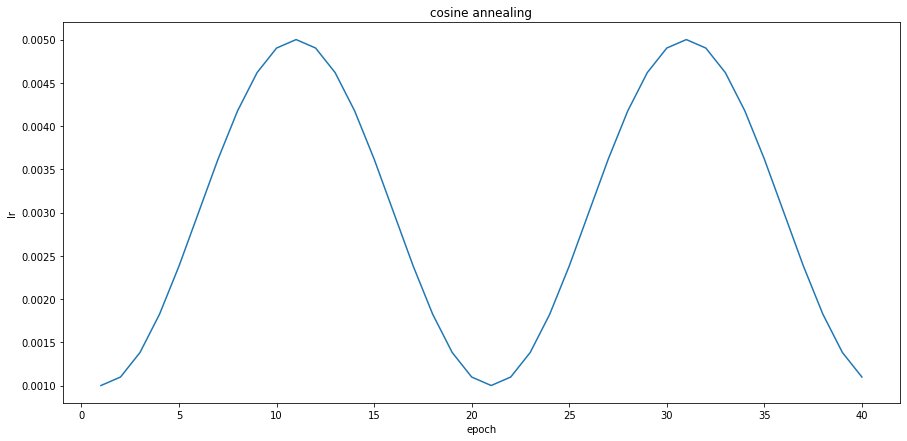

In [12]:
scheduler1 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.005)

lrs = []
for ep in tqdm(range(n_epochs)):
    lrs.append(optimizer.param_groups[0]["lr"])
    for batch, y in loader:
        optimizer.zero_grad()
#         batch = batch.to(DEVICE)
        output = model(batch)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    scheduler1.step()
    
plt.figure(figsize=(15, 7))
plt.title("cosine annealing")
plt.plot(np.arange(1, n_epochs + 1), lrs)
plt.xlabel("epoch")
plt.ylabel("lr");

In [21]:
num_samples, num_features = int(1e2), int(1e1)
X = torch.rand(num_samples, num_features)
y = torch.randint(0, 5, size=[num_samples])
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, num_workers=1)

model = torch.nn.Linear(num_features, 5)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)

100%|██████████| 40/40 [00:01<00:00, 31.94it/s]


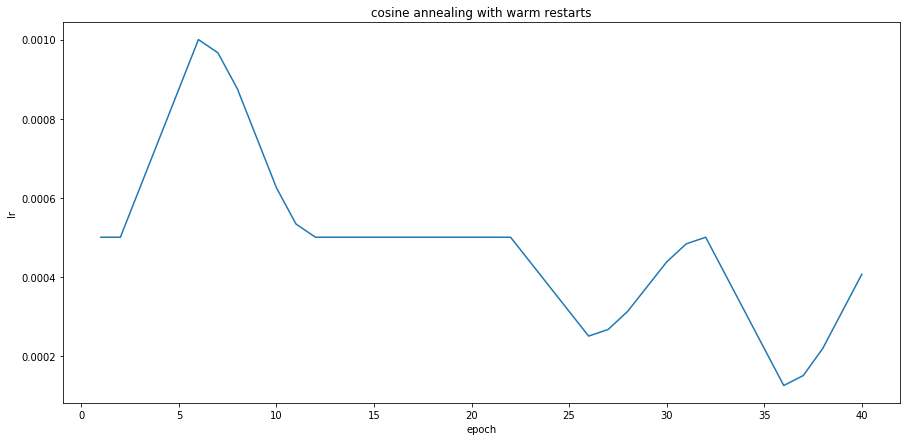

In [22]:
scheduler2 = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_up=4, eta_max=0.001, gamma=0.5)

lrs = []
for ep in tqdm(range(n_epochs)):
    lrs.append(optimizer.param_groups[0]["lr"])
    for batch, y in loader:
        optimizer.zero_grad()
#         batch = batch.to(DEVICE)
        output = model(batch)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    scheduler2.step()
    
plt.figure(figsize=(15, 7))
plt.title("cosine annealing with warm restarts")
plt.plot(np.arange(1, n_epochs + 1), lrs)
plt.xlabel("epoch")
plt.ylabel("lr");

In [20]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[ 0.0231,  0.0151, -0.0900,  0.2084, -0.0928, -0.0408,  0.2066, -0.1145,
             0.2010,  0.1899],
           [ 0.2294,  0.0546,  0.0504, -0.0282,  0.0931, -0.1037, -0.0760, -0.3167,
            -0.1549, -0.3066],
           [ 0.1315, -0.2174,  0.2138,  0.0135,  0.0537,  0.0171,  0.3055,  0.1245,
            -0.2445, -0.1362],
           [-0.0724,  0.1907, -0.1488,  0.2013,  0.2262, -0.2543, -0.0073, -0.1084,
            -0.2132,  0.1229],
           [-0.1585, -0.1303,  0.2669,  0.1191, -0.1757, -0.0172, -0.1356, -0.1824,
             0.0500,  0.1126]], requires_grad=True), Parameter containing:
   tensor([-0.1103,  0.2237, -0.1358,  0.2763,  0.1900], requires_grad=True)],
  'lr': 0.000941386114155692,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'initial_lr': 0.001}]